In [50]:
import torch
import torch.nn as nn
from google.colab import drive
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!unzip "./gdrive/My Drive/Assignment5 part2 dataset/A_05_Part_02_Dataset.zip" -d "./gdrive/My Drive"

In [0]:
data_dir = 'gdrive/My Drive/A_05_Part_02_Dataset/'

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers = 4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True, num_workers = 4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers = 4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


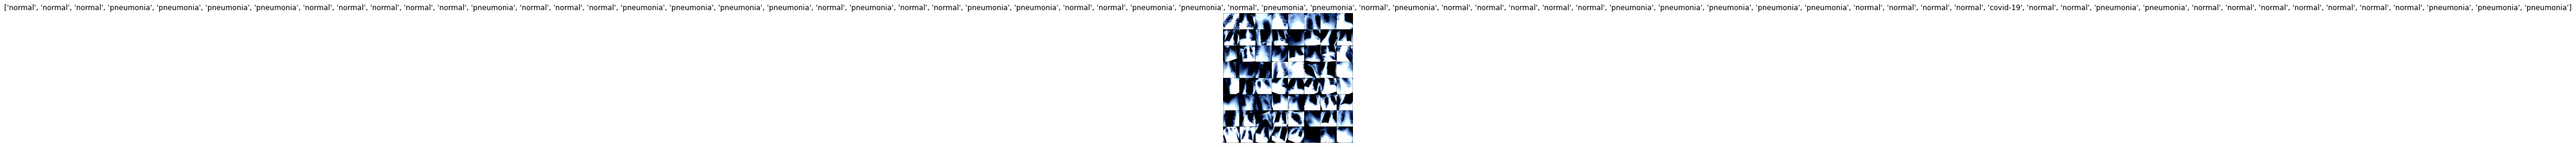

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [6]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000
print('\n\n<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<   ResNet-18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n')
print('\n',resnet18)
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000   

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# Freeze training for all convolution layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
# Freeze training for all layers above FC in ResNet18
child_counter = 0
for child in resnet18.children():
   #print(" child", child_counter, "is:")
   #print(child)
   child_counter += 1
   if child_counter < 9:
     for param in child.parameters():
        param.requires_grad = False


In [9]:
#num_features_0 = vgg16.classifier[0].in_features

features = [nn.Linear(in_features=25088, out_features=540, bias=True), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(in_features=540, out_features=3, bias=True)]
print(features)


[Linear(in_features=25088, out_features=540, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=540, out_features=3, bias=True)]


In [10]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
resnet18.fc = nn.Sequential(nn.Linear(512,540), nn.Linear(540, 3))
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **VGG-16**

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [65]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

sigmoid = nn.Sigmoid()
        
vgg16.train()
losses = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)              #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = criterion(outputs, target)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.161996: : 0it [00:05, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.161996: : 1it [00:05,  5.80s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.176104: : 1it [00:06,  5.80s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.176104: : 2it [00:06,  4.22s/it]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.147861: : 2it [00:06,  4.22s/it]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.147861: : 3it [00:06,  3.14s/it]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.192685: : 3it [00:07,  3.14s/it]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.192685: : 4it [00:07,  2.36s/it]
Train Epoch: 0 [256/6200 (4%)]	Loss: 0.172561: : 4it [00:11,  2.36s/it]
Train Epoch: 0 [256/6200 (4%)]	Loss: 0.172561: : 5it [00:11,  2.71s/it]
Train Epoch: 0 [320/6200 (5%)]	Loss: 0.118466: : 5it [00:11,  2.71s/it]
Train Epoch: 0 [320/6200 (5%)]	Loss: 0.118466: : 6it [00:11,  2.13s/it]
Train Epoch: 0 [384/6200 (6%)]	Loss: 0.137540: : 6it [00:12,  2.13s/it]
Train Epoch: 0 [384/6200 (6%)]	Loss: 0.137540: : 7it [

Finished Training


In [14]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1
              
        print("\n Total=",total)
        print("correct=",correct)

print('Accuracy of the network on the 6200 Train images: %d %%' % (100 * correct / total))


 Total= 64
correct= 55

 Total= 128
correct= 116

 Total= 192
correct= 175

 Total= 256
correct= 231

 Total= 320
correct= 287

 Total= 384
correct= 344

 Total= 448
correct= 401

 Total= 512
correct= 459

 Total= 576
correct= 514

 Total= 640
correct= 571

 Total= 704
correct= 627

 Total= 768
correct= 686

 Total= 832
correct= 742

 Total= 896
correct= 798

 Total= 960
correct= 853

 Total= 1024
correct= 912

 Total= 1088
correct= 970

 Total= 1152
correct= 1028

 Total= 1216
correct= 1083

 Total= 1280
correct= 1142

 Total= 1344
correct= 1199

 Total= 1408
correct= 1256

 Total= 1472
correct= 1310

 Total= 1536
correct= 1367

 Total= 1600
correct= 1428

 Total= 1664
correct= 1483

 Total= 1728
correct= 1540

 Total= 1792
correct= 1594

 Total= 1856
correct= 1653

 Total= 1920
correct= 1711

 Total= 1984
correct= 1773

 Total= 2048
correct= 1835

 Total= 2112
correct= 1885

 Total= 2176
correct= 1946

 Total= 2240
correct= 2002

 Total= 2304
correct= 2056

 Total= 2368
correct= 211

In [15]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1
              
        print("\n Total=",total)
        print("correct=",correct)

print('Accuracy of the network on the 628 Validation images: %d %%' % (100 * correct / total))


 Total= 64
correct= 59

 Total= 128
correct= 118

 Total= 192
correct= 176

 Total= 256
correct= 238

 Total= 320
correct= 294

 Total= 384
correct= 351

 Total= 448
correct= 410

 Total= 512
correct= 468

 Total= 576
correct= 524

 Total= 628
correct= 574
Accuracy of the network on the 628 Validation images: 91 %


In [16]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

sigmoid = nn.Sigmoid()
        
vgg16.train()
val_losses = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        image, labels = data
        image, labels = image.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(image)              #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(image), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = criterion(outputs, target)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(image), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    
    epoch_loss = running_loss / len(validationloader)
    val_losses.append(epoch_loss)

print('Finished Training')

Train Epoch: 0 [468/628 (90%)]	Loss: 0.079604: : 10it [00:12,  1.21s/it]
Train Epoch: 1 [468/628 (90%)]	Loss: 0.105007: : 10it [00:12,  1.23s/it]
Train Epoch: 2 [468/628 (90%)]	Loss: 0.141141: : 10it [00:12,  1.23s/it]
Train Epoch: 3 [468/628 (90%)]	Loss: 0.098288: : 10it [00:12,  1.26s/it]
Train Epoch: 4 [468/628 (90%)]	Loss: 0.060421: : 10it [00:12,  1.24s/it]
Train Epoch: 5 [468/628 (90%)]	Loss: 0.169273: : 10it [00:12,  1.24s/it]
Train Epoch: 6 [468/628 (90%)]	Loss: 0.097088: : 10it [00:12,  1.23s/it]
Train Epoch: 7 [468/628 (90%)]	Loss: 0.029854: : 10it [00:12,  1.22s/it]
Train Epoch: 8 [468/628 (90%)]	Loss: 0.015908: : 10it [00:12,  1.23s/it]
Train Epoch: 9 [468/628 (90%)]	Loss: 0.029138: : 10it [00:12,  1.24s/it]

Finished Training


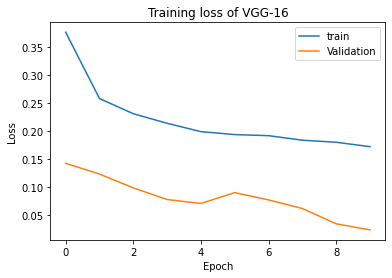

In [17]:
plt.title("Training loss of VGG-16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train','Validation'])
plt.show()

In [18]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = True, num_workers = 4)

sigmoid = nn.Sigmoid()
Names = []
hot_output = []
c = 0

mylist_of_list = []
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        for i in range(len(images)):
            hot_output.append(pred.data.cpu().numpy()[i])

        for i in range(len(images)):
            img_name, _  = testloader.dataset.samples[c]
            splitted = img_name.split('/')
            Names.append(splitted[-1])
            c += 1
print('Length hot output = ',len(hot_output))

for i in range(0,c):
    temp = []
    temp.append(Names[i])
    temp.append(hot_output[i][0])
    temp.append(hot_output[i][1])
    temp.append(hot_output[i][2])
    mylist_of_list.append(temp)

print(mylist_of_list)

Length hot output =  629
[['0.png', 0.0, 0.0, 1.0], ['1.png', 0.0, 0.0, 1.0], ['10.png', 0.0, 0.0, 1.0], ['100.png', 1.0, 1.0, 0.0], ['101.png', 0.0, 1.0, 0.0], ['102.png', 0.0, 0.0, 1.0], ['103.png', 0.0, 1.0, 0.0], ['104.jpg', 0.0, 1.0, 0.0], ['105.jpg', 0.0, 0.0, 1.0], ['106.png', 0.0, 0.0, 1.0], ['107.png', 0.0, 0.0, 1.0], ['108.png', 0.0, 1.0, 0.0], ['109.png', 0.0, 1.0, 0.0], ['11.png', 0.0, 1.0, 0.0], ['110.png', 0.0, 0.0, 1.0], ['111.png', 0.0, 0.0, 1.0], ['112.png', 0.0, 1.0, 0.0], ['113.png', 0.0, 1.0, 0.0], ['114.png', 0.0, 0.0, 1.0], ['115.png', 0.0, 1.0, 0.0], ['116.png', 0.0, 0.0, 1.0], ['117.png', 0.0, 0.0, 1.0], ['118.png', 0.0, 0.0, 1.0], ['119.png', 0.0, 0.0, 1.0], ['12.png', 0.0, 0.0, 1.0], ['120.png', 0.0, 0.0, 1.0], ['121.png', 0.0, 1.0, 0.0], ['122.png', 0.0, 0.0, 1.0], ['123.png', 0.0, 0.0, 1.0], ['124.png', 0.0, 0.0, 1.0], ['125.png', 0.0, 0.0, 1.0], ['126.png', 0.0, 0.0, 1.0], ['127.png', 0.0, 1.0, 0.0], ['128.png', 1.0, 1.0, 0.0], ['129.png', 0.0, 1.0, 0.0], [

In [19]:
import pandas as pd
df = pd.DataFrame(mylist_of_list)
print(df.head())
df.to_csv('VGG16_WOL.csv', index = False, header = False)

         0    1    2    3
0    0.png  0.0  0.0  1.0
1    1.png  0.0  0.0  1.0
2   10.png  0.0  0.0  1.0
3  100.png  1.0  1.0  0.0
4  101.png  0.0  1.0  0.0


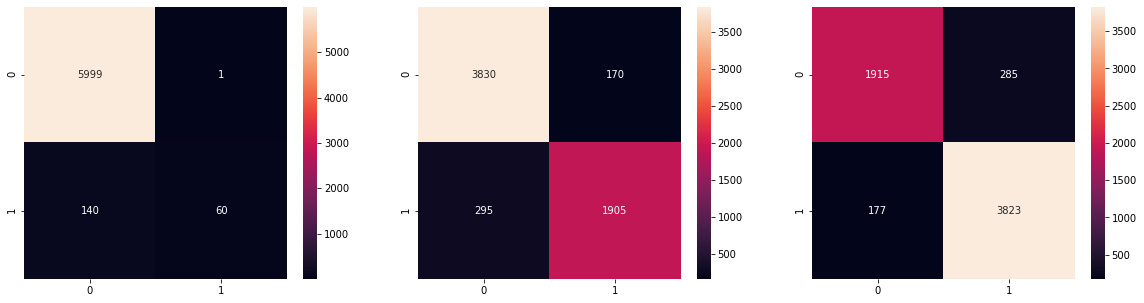

In [66]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

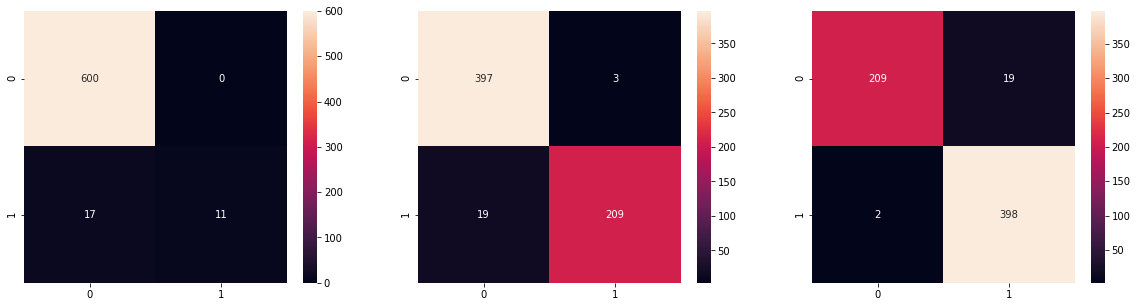

In [67]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

## Resnet 18

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)

In [44]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

sigmoid = nn.Sigmoid()
        
resnet18.train()
losses = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = criterion(outputs, target)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    torch.save(resnet18.state_dict(), 'Res18_FC_WoFL_Only.pth')

print('Finished Training')

Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.174653: : 97it [01:57,  1.21s/it]
Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.278453: : 97it [01:57,  1.21s/it]
Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.202702: : 97it [01:57,  1.21s/it]
Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.360800: : 97it [01:56,  1.20s/it]
Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.195283: : 97it [01:56,  1.20s/it]
Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.267468: : 97it [01:56,  1.20s/it]
Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.266724: : 97it [02:02,  1.26s/it]
Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.350072: : 97it [01:59,  1.23s/it]
Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.275782: : 97it [01:59,  1.24s/it]
Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.183731: : 97it [02:00,  1.24s/it]

Finished Training


In [45]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1

print('Accuracy of the network on the 6200 Train images: %d %%' % (100 * correct / total))

Accuracy of the network on the 6200 Train images: 85 %


In [46]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1

print('Accuracy of the network on the 628 validation images: %d %%' % (100 * correct / total))

Accuracy of the network on the 628 validation images: 87 %


In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

sigmoid = nn.Sigmoid()
        
resnet18.train()
val_losses = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader), position=0, leave=True)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = criterion(outputs, target)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    
    epoch_loss = running_loss / len(validationloader)
    val_losses.append(epoch_loss)


print('Finished Training')



0it [00:00, ?it/s]

Train Epoch: 0 [0/628 (0%)]	Loss: 0.248364: : 0it [00:03, ?it/s]

Train Epoch: 0 [0/628 (0%)]	Loss: 0.248364: : 1it [00:03,  3.69s/it]

Train Epoch: 0 [64/628 (10%)]	Loss: 0.203926: : 1it [00:04,  3.69s/it]

Train Epoch: 0 [64/628 (10%)]	Loss: 0.203926: : 2it [00:04,  2.68s/it]

Train Epoch: 0 [128/628 (20%)]	Loss: 0.290273: : 2it [00:04,  2.68s/it]

Train Epoch: 0 [128/628 (20%)]	Loss: 0.290273: : 3it [00:04,  2.01s/it]

Train Epoch: 0 [192/628 (30%)]	Loss: 0.310858: : 3it [00:04,  2.01s/it]

Train Epoch: 0 [192/628 (30%)]	Loss: 0.310858: : 4it [00:04,  1.45s/it]

Train Epoch: 0 [256/628 (40%)]	Loss: 0.285207: : 4it [00:07,  1.45s/it]

Train Epoch: 0 [256/628 (40%)]	Loss: 0.285207: : 5it [00:07,  1.92s/it]

Train Epoch: 0 [320/628 (50%)]	Loss: 0.237051: : 5it [00:07,  1.92s/it]

Train Epoch: 0 [320/628 (50%)]	Loss: 0.237051: : 6it [00:07,  1.37s/it]

Train Epoch: 0 [384/628 (60%)]	Loss: 0.282086: : 6it [00:07,  1.37s/it]

Train Epoch: 0 [384/628 (60%)]	Loss: 0.28

Finished Training


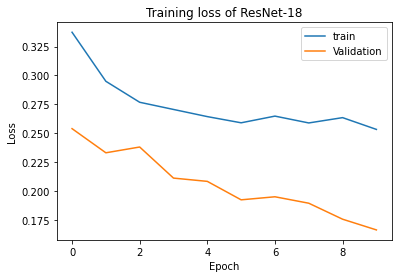

In [0]:
plt.title("Training loss of ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train','Validation'])
plt.show()

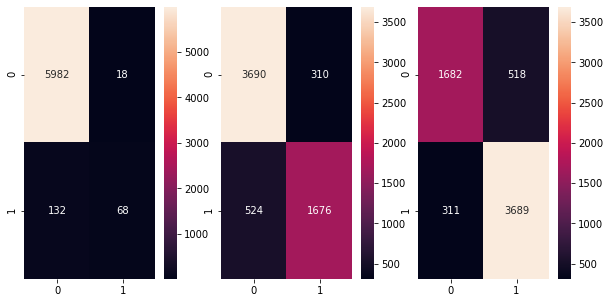

In [53]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

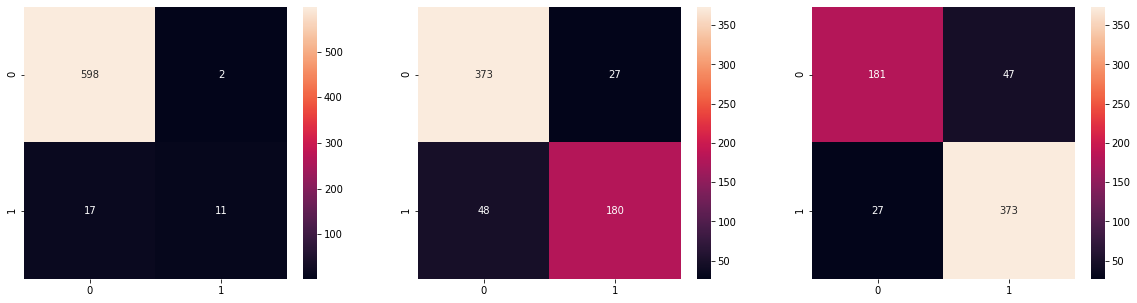

In [55]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

In [56]:
sigmoid = nn.Sigmoid()
Names = []
hot_output = []
c = 0
mylist_of_list = []

with torch.no_grad():
    for data in testloader:
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        for i in range(len(images)):
            hot_output.append(pred.data.cpu().numpy()[i])

        for i in range(len(images)):
            img_name, _  = testloader.dataset.samples[c]
            splitted = img_name.split('/')
            Names.append(splitted[-1])
            c += 1
print('Length hot output = ',len(hot_output))

for i in range(0,c):
    temp = []
    temp.append(Names[i])
    temp.append(hot_output[i][0])
    temp.append(hot_output[i][1])
    temp.append(hot_output[i][2])
    mylist_of_list.append(temp)

print(mylist_of_list)

Length hot output =  629
[['0.png', 0.0, 1.0, 0.0], ['1.png', 0.0, 0.0, 1.0], ['10.png', 0.0, 1.0, 0.0], ['100.png', 0.0, 1.0, 0.0], ['101.png', 0.0, 1.0, 0.0], ['102.png', 0.0, 0.0, 1.0], ['103.png', 0.0, 0.0, 1.0], ['104.jpg', 0.0, 0.0, 1.0], ['105.jpg', 0.0, 0.0, 1.0], ['106.png', 0.0, 0.0, 1.0], ['107.png', 0.0, 0.0, 1.0], ['108.png', 0.0, 0.0, 1.0], ['109.png', 0.0, 0.0, 1.0], ['11.png', 0.0, 1.0, 0.0], ['110.png', 0.0, 0.0, 1.0], ['111.png', 0.0, 0.0, 1.0], ['112.png', 0.0, 1.0, 0.0], ['113.png', 0.0, 0.0, 1.0], ['114.png', 0.0, 0.0, 1.0], ['115.png', 0.0, 0.0, 1.0], ['116.png', 0.0, 0.0, 1.0], ['117.png', 0.0, 1.0, 0.0], ['118.png', 0.0, 1.0, 0.0], ['119.png', 0.0, 0.0, 1.0], ['12.png', 0.0, 0.0, 1.0], ['120.png', 0.0, 0.0, 1.0], ['121.png', 0.0, 0.0, 1.0], ['122.png', 0.0, 1.0, 0.0], ['123.png', 0.0, 0.0, 1.0], ['124.png', 0.0, 0.0, 1.0], ['125.png', 0.0, 0.0, 1.0], ['126.png', 0.0, 1.0, 0.0], ['127.png', 0.0, 0.0, 1.0], ['128.png', 0.0, 1.0, 0.0], ['129.png', 0.0, 1.0, 0.0], [

In [57]:
import pandas as pd
df = pd.DataFrame(mylist_of_list)
print(df.head())
df.to_csv('ResNet18_WoL.csv', index = False, header = False)

         0    1    2    3
0    0.png  0.0  1.0  0.0
1    1.png  0.0  0.0  1.0
2   10.png  0.0  1.0  0.0
3  100.png  0.0  1.0  0.0
4  101.png  0.0  1.0  0.0


 # **Task 2 with Focal loss**

In [0]:
def Focal_Loss(y_pred, Y, alpha, gamma):
    criterion = nn.BCEWithLogitsLoss()
    BCEloss = criterion(y_pred,Y)
    pt = torch.exp(-BCEloss)
    F_loss = alpha * ((1-pt)**gamma) * BCEloss
    return torch.mean(F_loss)

ResNet-18

In [0]:
Epochs = 10
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)

In [61]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

sigmoid = nn.Sigmoid()
        
resnet18.train()
losses = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = Focal_Loss(outputs, target, 0.25, 2)   #----> compute loss
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    torch.save(resnet18.state_dict(), 'Res18_FC_FL_Only.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.002597: : 0it [00:04, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.002597: : 1it [00:04,  4.74s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.002439: : 1it [00:04,  4.74s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.002439: : 2it [00:04,  3.38s/it]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.004617: : 2it [00:05,  3.38s/it]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.004617: : 3it [00:05,  2.43s/it]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.001357: : 3it [00:06,  2.43s/it]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.001357: : 4it [00:06,  2.04s/it]
Train Epoch: 0 [256/6200 (4%)]	Loss: 0.004244: : 4it [00:09,  2.04s/it]
Train Epoch: 0 [256/6200 (4%)]	Loss: 0.004244: : 5it [00:09,  2.48s/it]
Train Epoch: 0 [320/6200 (5%)]	Loss: 0.003090: : 5it [00:10,  2.48s/it]
Train Epoch: 0 [320/6200 (5%)]	Loss: 0.003090: : 6it [00:10,  1.82s/it]
Train Epoch: 0 [384/6200 (6%)]	Loss: 0.000805: : 6it [00:10,  1.82s/it]
Train Epoch: 0 [384/6200 (6%)]	Loss: 0.000805: : 7it [

Finished Training


In [23]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

sigmoid = nn.Sigmoid()
        
resnet18.train()
val_losses = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)             #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = Focal_Loss(outputs, target, 0.25, 2)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    
    epoch_loss = running_loss / len(validationloader)
    val_losses.append(epoch_loss)


print('Finished Training')

Train Epoch: 0 [468/628 (90%)]	Loss: 0.011365: : 10it [00:10,  1.10s/it]
Train Epoch: 1 [468/628 (90%)]	Loss: 0.008232: : 10it [00:11,  1.11s/it]
Train Epoch: 2 [468/628 (90%)]	Loss: 0.003253: : 10it [00:11,  1.12s/it]
Train Epoch: 3 [468/628 (90%)]	Loss: 0.010205: : 10it [00:11,  1.12s/it]
Train Epoch: 4 [468/628 (90%)]	Loss: 0.006203: : 10it [00:10,  1.08s/it]
Train Epoch: 5 [468/628 (90%)]	Loss: 0.012675: : 10it [00:10,  1.09s/it]
Train Epoch: 6 [468/628 (90%)]	Loss: 0.006352: : 10it [00:10,  1.08s/it]
Train Epoch: 7 [468/628 (90%)]	Loss: 0.003081: : 10it [00:10,  1.06s/it]
Train Epoch: 8 [468/628 (90%)]	Loss: 0.012751: : 10it [00:10,  1.08s/it]
Train Epoch: 9 [468/628 (90%)]	Loss: 0.002821: : 10it [00:10,  1.07s/it]

Finished Training


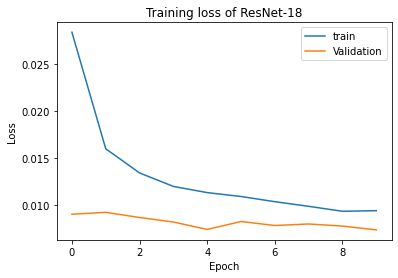

In [24]:
plt.title("Training loss of ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train','Validation'])
plt.show()

In [25]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1

print('Accuracy of the network on the 6200 Train images: %d %%' % (100 * correct / total))


 Total= 64
correct= 51

 Total= 128
correct= 107

 Total= 192
correct= 163

 Total= 256
correct= 212

 Total= 320
correct= 263

 Total= 384
correct= 315

 Total= 448
correct= 367

 Total= 512
correct= 421

 Total= 576
correct= 471

 Total= 640
correct= 519

 Total= 704
correct= 573

 Total= 768
correct= 625

 Total= 832
correct= 681

 Total= 896
correct= 734

 Total= 960
correct= 786

 Total= 1024
correct= 840

 Total= 1088
correct= 891

 Total= 1152
correct= 942

 Total= 1216
correct= 998

 Total= 1280
correct= 1046

 Total= 1344
correct= 1100

 Total= 1408
correct= 1155

 Total= 1472
correct= 1206

 Total= 1536
correct= 1259

 Total= 1600
correct= 1319

 Total= 1664
correct= 1371

 Total= 1728
correct= 1422

 Total= 1792
correct= 1473

 Total= 1856
correct= 1525

 Total= 1920
correct= 1576

 Total= 1984
correct= 1629

 Total= 2048
correct= 1685

 Total= 2112
correct= 1744

 Total= 2176
correct= 1795

 Total= 2240
correct= 1847

 Total= 2304
correct= 1901

 Total= 2368
correct= 1951


In [26]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1

print('Accuracy of the network on the 628 validation images: %d %%' % (100 * correct / total))


 Total= 64
correct= 56

 Total= 128
correct= 113

 Total= 192
correct= 166

 Total= 256
correct= 221

 Total= 320
correct= 277

 Total= 384
correct= 333

 Total= 448
correct= 390

 Total= 512
correct= 442

 Total= 576
correct= 498

 Total= 628
correct= 539
Accuracy of the network on the 628 validation images: 85 %


In [27]:
sigmoid = nn.Sigmoid()
Names = []
hot_output = []
c = 0
mylist_of_list = []

with torch.no_grad():
    for data in testloader:
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        for i in range(len(images)):
            hot_output.append(pred.data.cpu().numpy()[i])

        for i in range(len(images)):
            img_name, _  = testloader.dataset.samples[c]
            splitted = img_name.split('/')
            Names.append(splitted[-1])
            c += 1
print('Length hot output = ',len(hot_output))

for i in range(0,c):
    temp = []
    temp.append(Names[i])
    temp.append(hot_output[i][0])
    temp.append(hot_output[i][1])
    temp.append(hot_output[i][2])
    mylist_of_list.append(temp)

print(mylist_of_list)

Length hot output =  629
[['0.png', 0.0, 1.0, 0.0], ['1.png', 0.0, 1.0, 0.0], ['10.png', 0.0, 0.0, 0.0], ['100.png', 0.0, 1.0, 0.0], ['101.png', 0.0, 0.0, 1.0], ['102.png', 0.0, 0.0, 1.0], ['103.png', 0.0, 0.0, 1.0], ['104.jpg', 0.0, 1.0, 0.0], ['105.jpg', 0.0, 1.0, 0.0], ['106.png', 0.0, 0.0, 1.0], ['107.png', 0.0, 1.0, 0.0], ['108.png', 0.0, 0.0, 1.0], ['109.png', 0.0, 0.0, 1.0], ['11.png', 0.0, 1.0, 0.0], ['110.png', 0.0, 0.0, 1.0], ['111.png', 0.0, 0.0, 1.0], ['112.png', 0.0, 1.0, 0.0], ['113.png', 0.0, 0.0, 1.0], ['114.png', 0.0, 0.0, 1.0], ['115.png', 0.0, 1.0, 0.0], ['116.png', 0.0, 0.0, 1.0], ['117.png', 0.0, 1.0, 0.0], ['118.png', 0.0, 0.0, 1.0], ['119.png', 0.0, 0.0, 1.0], ['12.png', 0.0, 0.0, 1.0], ['120.png', 0.0, 0.0, 1.0], ['121.png', 0.0, 1.0, 0.0], ['122.png', 0.0, 0.0, 1.0], ['123.png', 0.0, 0.0, 1.0], ['124.png', 0.0, 0.0, 1.0], ['125.png', 0.0, 0.0, 1.0], ['126.png', 0.0, 0.0, 1.0], ['127.png', 0.0, 0.0, 1.0], ['128.png', 0.0, 0.0, 1.0], ['129.png', 0.0, 1.0, 0.0], [

In [28]:
import pandas as pd
df = pd.DataFrame(mylist_of_list)
print(df.head())
df.to_csv('ResNet18_WFL.csv', index = False, header = False)

         0    1    2    3
0    0.png  0.0  1.0  0.0
1    1.png  0.0  1.0  0.0
2   10.png  0.0  0.0  0.0
3  100.png  0.0  1.0  0.0
4  101.png  0.0  0.0  1.0


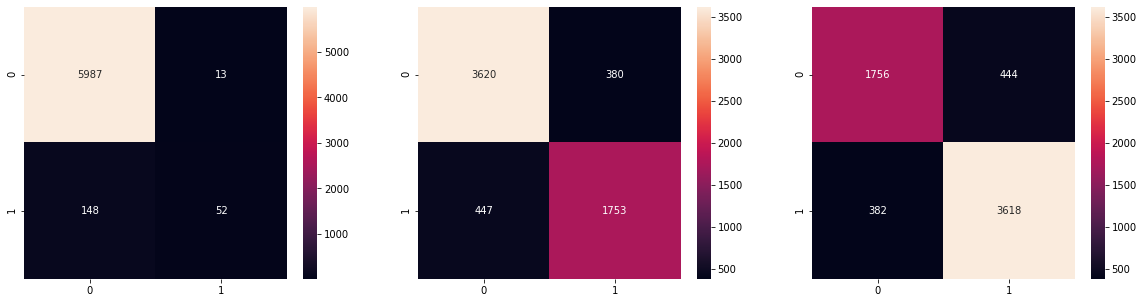

In [62]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

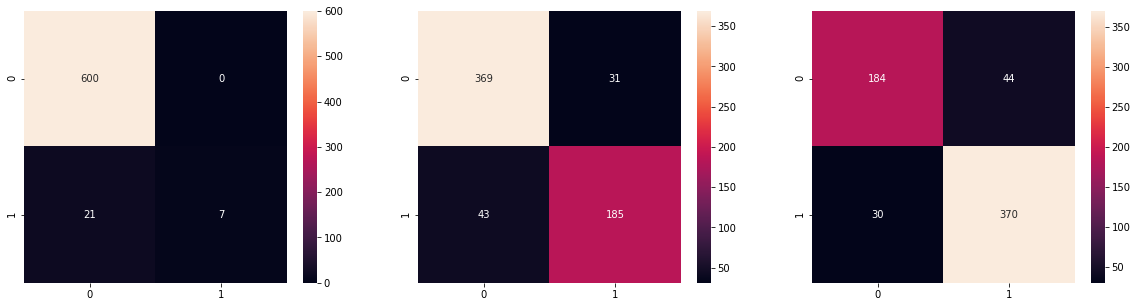

In [63]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = resnet18(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

VGG-16

In [0]:
Epochs = 12
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [30]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

sigmoid = nn.Sigmoid()
        
vgg16.train()
losses = []

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = Focal_Loss(outputs, target, 0.25, 2)   #----> compute loss
        
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    torch.save(vgg16.state_dict(), 'vgg16_FC_FL_Only.pth')

print('Finished Training')

Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.000729: : 97it [02:04,  1.28s/it]
Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.000374: : 97it [02:04,  1.29s/it]
Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.002763: : 97it [02:06,  1.30s/it]
Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.000473: : 97it [02:05,  1.29s/it]
Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.000287: : 97it [02:05,  1.30s/it]
Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.000107: : 97it [02:11,  1.35s/it]
Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.001872: : 97it [02:07,  1.32s/it]
Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.001111: : 97it [02:07,  1.31s/it]
Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.001357: : 97it [02:07,  1.31s/it]
Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.001091: : 97it [02:07,  1.31s/it]
Train Epoch: 10 [5376/6200 (99%)]	Loss: 0.000296: : 97it [02:08,  1.33s/it]
Train Epoch: 11 [5376/6200 (99%)]	Loss: 0.002181: : 97it [02:07,  1.32s/it]


Finished Training


In [36]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

sigmoid = nn.Sigmoid()
        
vgg16.train()
val_losses = []


for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader), position=0, leave=True)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        #print('\n outputs = ', outputs)
        
        #pos_weight = torch.ones([3])  # All weights are equal to 1
        target = torch.zeros([len(inputs), 3])
        target = target.to(device)
        #print('\nTarget Shape = ',target.shape)
        for j in range(0,len(labels)):
            if labels[j] == 0:
              target[j][0] = 1
              target[j][1] = 1
              target[j][2] = 0

            elif labels[j] == 1:
              target[j][0] = 0
              target[j][1] = 0
              target[j][2] = 1

            elif labels[j] == 2:
              target[j][0] = 0
              target[j][1] = 1
              target[j][2] = 0

        #print("Target = ",target)
        loss = Focal_Loss(outputs, target, 0.25, 2)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    
    epoch_loss = running_loss / len(validationloader)
    val_losses.append(epoch_loss)


print('Finished Training')

Train Epoch: 0 [468/628 (90%)]	Loss: 0.000015: : 10it [00:12,  1.25s/it]
Train Epoch: 1 [468/628 (90%)]	Loss: 0.000020: : 10it [00:12,  1.26s/it]
Train Epoch: 2 [468/628 (90%)]	Loss: 0.000050: : 10it [00:12,  1.28s/it]
Train Epoch: 3 [468/628 (90%)]	Loss: 0.000027: : 10it [00:12,  1.24s/it]
Train Epoch: 4 [468/628 (90%)]	Loss: 0.000043: : 10it [00:12,  1.26s/it]
Train Epoch: 5 [468/628 (90%)]	Loss: 0.000047: : 10it [00:12,  1.25s/it]
Train Epoch: 6 [468/628 (90%)]	Loss: 0.000003: : 10it [00:12,  1.21s/it]
Train Epoch: 7 [468/628 (90%)]	Loss: 0.000055: : 10it [00:12,  1.24s/it]
Train Epoch: 8 [468/628 (90%)]	Loss: 0.000027: : 10it [00:12,  1.28s/it]
Train Epoch: 9 [468/628 (90%)]	Loss: 0.000064: : 10it [00:12,  1.26s/it]
Train Epoch: 10 [468/628 (90%)]	Loss: 0.000054: : 10it [00:12,  1.25s/it]
Train Epoch: 11 [468/628 (90%)]	Loss: 0.000018: : 10it [00:12,  1.25s/it]

Finished Training


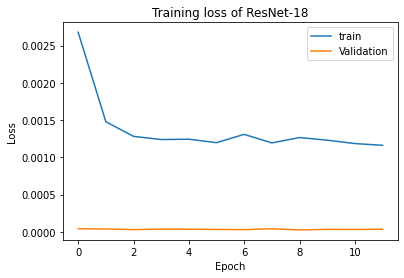

In [37]:
plt.title("Training loss of ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train','Validation'])
plt.show()

In [38]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1
            
print('Accuracy of the network on the 6200 Train images: %d %%' % (100 * correct / total))

Accuracy of the network on the 6200 Train images: 89 %


In [39]:
correct = 0
total = 0
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)

        #_, predicted = torch.max(outputs.data, 1)
        total += oneHot.size(0)
        #correct += (pred == oneHot).sum().item()
        for j in range(0,oneHot.size(0)):
          if(pred[j]==oneHot[j]).sum()==3:
              correct+=1
              
print('Accuracy of the network on the 628 validation images: %d %%' % (100 * correct / total))

Accuracy of the network on the 628 validation images: 97 %


In [40]:
sigmoid = nn.Sigmoid()
Names = []
hot_output = []
c = 0
mylist_of_list = []

with torch.no_grad():
    for data in testloader:
        images, labels = data

        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        for i in range(len(images)):
            hot_output.append(pred.data.cpu().numpy()[i])

        for i in range(len(images)):
            img_name, _  = testloader.dataset.samples[c]
            splitted = img_name.split('/')
            Names.append(splitted[-1])
            c += 1
print('Length hot output = ',len(hot_output))

for i in range(0,c):
    temp = []
    temp.append(Names[i])
    temp.append(hot_output[i][0])
    temp.append(hot_output[i][1])
    temp.append(hot_output[i][2])
    mylist_of_list.append(temp)

print(mylist_of_list)

Length hot output =  629
[['0.png', 0.0, 0.0, 1.0], ['1.png', 0.0, 1.0, 0.0], ['10.png', 0.0, 1.0, 0.0], ['100.png', 0.0, 0.0, 1.0], ['101.png', 0.0, 0.0, 1.0], ['102.png', 0.0, 0.0, 1.0], ['103.png', 0.0, 0.0, 1.0], ['104.jpg', 0.0, 0.0, 1.0], ['105.jpg', 0.0, 0.0, 1.0], ['106.png', 0.0, 0.0, 1.0], ['107.png', 0.0, 0.0, 1.0], ['108.png', 0.0, 0.0, 1.0], ['109.png', 0.0, 0.0, 1.0], ['11.png', 0.0, 0.0, 1.0], ['110.png', 0.0, 1.0, 0.0], ['111.png', 0.0, 0.0, 1.0], ['112.png', 0.0, 1.0, 0.0], ['113.png', 0.0, 0.0, 1.0], ['114.png', 0.0, 1.0, 0.0], ['115.png', 0.0, 1.0, 0.0], ['116.png', 1.0, 1.0, 0.0], ['117.png', 0.0, 0.0, 1.0], ['118.png', 0.0, 0.0, 1.0], ['119.png', 0.0, 0.0, 1.0], ['12.png', 0.0, 0.0, 1.0], ['120.png', 0.0, 1.0, 0.0], ['121.png', 0.0, 0.0, 1.0], ['122.png', 0.0, 0.0, 1.0], ['123.png', 0.0, 1.0, 0.0], ['124.png', 0.0, 0.0, 1.0], ['125.png', 0.0, 1.0, 1.0], ['126.png', 0.0, 0.0, 1.0], ['127.png', 0.0, 0.0, 1.0], ['128.png', 0.0, 0.0, 1.0], ['129.png', 0.0, 0.0, 1.0], [

In [42]:
import pandas as pd
df = pd.DataFrame(mylist_of_list)
print(df.head())
df.to_csv('vgg16_WFL.csv', index = False, header = False)

         0    1    2    3
0    0.png  0.0  0.0  1.0
1    1.png  0.0  1.0  0.0
2   10.png  0.0  1.0  0.0
3  100.png  0.0  0.0  1.0
4  101.png  0.0  0.0  1.0


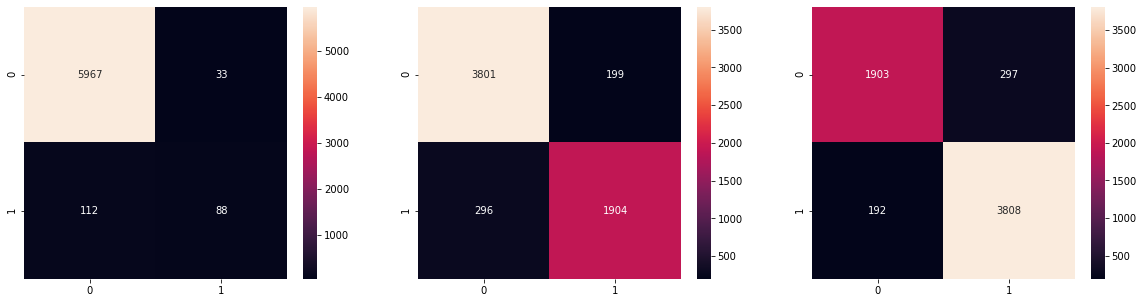

In [58]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in trainloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()

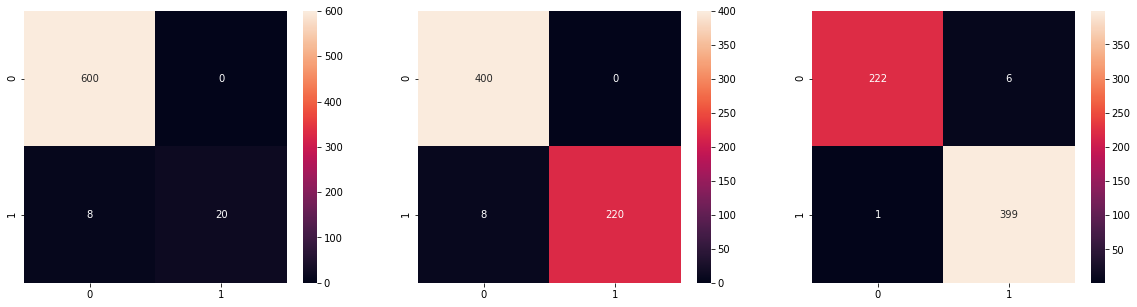

In [59]:
mat = np.zeros((3,2,2))

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        oneHot = torch.zeros([len(labels), 3])
        oneHot = oneHot.to(device)
        i = 0
        for l in labels:
            if l == 0:
              oneHot[i][0] = 1
              oneHot[i][1] = 1
              oneHot[i][2] = 0

            elif l == 1:
              oneHot[i][0] = 0
              oneHot[i][1] = 0
              oneHot[i][2] = 1

            elif l == 2:
              oneHot[i][0] = 0
              oneHot[i][1] = 1
              oneHot[i][2] = 0
            i = i+1
        images, oneHot = images.to(device), oneHot.to(device)
        outputs = vgg16(images)

        sigout = sigmoid(outputs)
        pred = torch.round(sigout)
        mat += multilabel_confusion_matrix(oneHot.data.to('cpu'), pred.data.to('cpu'))

mat0 = pd.DataFrame(mat[0], ['0', '1'], ['0', '1'])
mat1 = pd.DataFrame(mat[1], ['0', '1'], ['0', '1'])
mat2 = pd.DataFrame(mat[2], ['0', '1'], ['0', '1'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 5))

sns.heatmap(mat0, annot=True, ax=ax1, fmt='g')
sns.heatmap(mat1, annot=True, ax=ax2, fmt='g')
sns.heatmap(mat2, annot=True, ax=ax3, fmt='g')

plt.show()